In [4]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [5]:
file = pd.read_stata('hctms_data.dta')

## Wybrane zmienne - preprocessing
##### Ilościowe
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q9** - wiek partnera w 2017

##### Jakościowe
- **Q27** - czy ty i twój partner dorastaliście w tym samym mieście?
- **w6_q32**- czy wykorzystałeś internet do poznania partnera?

In [6]:
dt = file[['w6_number_people_met','age_when_met','Q9', 'ppage','w6_q32','S1','Q27','w6_q21b_year','w6_q21c_year','Q21A_Year','w6_q9']].dropna().reset_index(drop = True)

In [7]:
# S1 - Is married?
dt['S1'] = 1 - dt['S1'].cat.codes


# w6_q32 - Did you use internet to meet partner?
dt['w6_q32'] = dt['w6_q32'].str.replace('No.*','0')
dt['w6_q32'] = dt['w6_q32'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['w6_q32'] == 'Refused')]
dt['w6_q32'] = pd.to_numeric(dt['w6_q32'])

# Q27 - The same city with partner?
dt['Q27'] = dt['Q27'].str.replace('No.*','0')
dt['Q27'] = dt['Q27'].str.replace('Yes.*','1')
dt = dt.loc[~(dt['Q27'] == 'Refused')]
dt['Q27'] = pd.to_numeric(dt['Q27'])

# Q21A_Year - In what Year and Month did you first meet 
dt = dt.loc[~(dt['Q21A_Year'] == 'Refused')]
dt['Q21A_Year'] = pd.to_numeric(dt['Q21A_Year'])

# w6_q9 - Partner age in 2017

features = dt[['Q21A_Year','w6_q9','Q27','w6_q32']]
labels = dt[['S1']]

In [8]:
features.head(10)

,Q21A_Year,w6_q9,Q27,w6_q32
0,1983,52.0,0,0
1,2006,45.0,0,1
2,1983,59.0,0,0
3,1981,60.0,0,0
4,1966,67.0,1,0
5,1967,65.0,1,0
6,2008,43.0,0,0
7,2007,35.0,0,0
8,2002,42.0,0,0
9,2007,37.0,0,0


## Stworzenie dwóch modeli

In [9]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.10, random_state = 0)

### Random Forests

In [9]:
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(train_features, train_labels)

predictions = model_rf.predict(test_features)
tested_labels = np.array(test_labels)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_rf, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 81.69 %


### Logistic Regression

In [21]:
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(train_features,train_labels)  

predictions = model_lr.predict(test_features)
tested_labels = np.array(test_labels)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_lr, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 82.93 %


### Funkcje pomocnicze

In [12]:
def perturbate(features, col_to_perturbate):
    """
    col_to_perturbate - index of column to perturbate
    sd_proc - percent of sd we want new data to be perturbated
    """
    features_per=features.copy()
    
    nrows=features.shape[0]
    avg=float(features.iloc[:,[col_to_perturbate]].mean())
    sd=float(features.iloc[:,[col_to_perturbate]].var())
    rand_vect=np.random.randn(nrows)
    
    features_per.iloc[:,[col_to_perturbate]]=np.sqrt(sd) * rand_vect + avg
    
    return features_per

def calculate_loss(model, features, labels):
    y_pred=model.predict(features).reshape(features.shape[0],1)
    y_true=labels.values
    return np.mean(abs(y_pred-y_true))

def variable_importance(model, features, labels):
    ncols=features.shape[1]
    colnames=features.columns
    
    features_losses=[]
    features_per_losses=[]
    
    for i in range(ncols):
        features_loss=calculate_loss(model, features, labels)
        features_losses.append(features_loss)
        
        features_per=perturbate(features, i)
        feature_per_loss=calculate_loss(model, features_per, labels)
        features_per_losses.append(feature_per_loss)
    
    losses_df=pd.DataFrame({'feature':colnames, 'loss':features_losses, 'per_loss':features_per_losses})
    losses_df['losses_diff']=losses_df['per_loss']-losses_df['loss']
    return losses_df

def plot_importance(losses_df):
    plt.barh(losses_df['feature'], losses_df['per_loss'])
    plt.xlim([np.mean(losses_df['loss']), max(losses_df['per_loss'])])
    plt.show()
    
def explain_model(model, features, feature_index, window):
    '''
    features - pandas DF
    feature_index - index kolumny dla której robimy wykresy
    '''
    
    colnames = list(features.columns)
    features = features.values
      
    # Draw figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # Ceteris Paribus lines for all observations and PD-plot
    unique_features = np.sort(np.unique(features[:,feature_index]))
    all_proba = []
    for j in range(features.shape[0]):
        x_to_predict = np.tile(features[j],(len(unique_features),1))
        x_to_predict[:,feature_index] = unique_features
        y = model.predict_proba(x_to_predict)[:,1]
        all_proba.append(y)
        axes[0].plot(unique_features,y, color = '0.75', zorder = 5)
    axes[0].scatter(features[:,feature_index], model.predict_proba(features.tolist())[:,1], c = 'black', s = 15, zorder = 10)
    axes[0].plot(unique_features, np.mean(all_proba, axis = 0), color = 'black',linewidth = 5 , zorder = 15, label = 'PD plot')
    
    # Magrinal effect plot and ALE plot data
    min_value, max_value = int(min(features[:,feature_index])), int(max(features[:,feature_index]))
    m_plot = []
    ale = []
    for i in range(min_value, max_value):
        # M-plot
        window_avg = np.mean(np.array(all_proba)[(features[:,feature_index] >= i - window) & (features[:,feature_index] < i + window)])
        m_plot.append(window_avg)
        
        #ALE-plot
        window_features = features[(features[:,feature_index] >= i - window) & (features[:,feature_index] < i + window)].copy()
        window_features[:,feature_index] = i - window
        proba_lower = model.predict_proba(window_features)[:,1]
        window_features[:,feature_index] = i + window
        proba_higher = model.predict_proba(window_features)[:,1]
        ale.append(np.mean((proba_higher - proba_lower)))
    
    ale = np.array(ale).cumsum()
    ale = ale - np.mean(ale)
        
    # M-plot
    axes[0].plot(range(min_value,max_value), m_plot, color = 'red',linewidth = 5 , zorder = 15, label = 'M-plot')
    
    # Plot features
    axes[0].set_title('PD-plot and M-plot for ' + colnames[feature_index])
    axes[0].legend()
    
    # ALE-plot
    axes[1].plot(range(min_value,max_value), ale, color = 'blue',linewidth = 5 , zorder = 15, label = 'ALE-plot')
    axes[1].set_title('ALE-plot for ' + colnames[feature_index])
    axes[1].legend()

### Macierz korelacji zmiennych

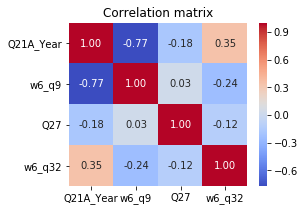

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title('Correlation matrix')
plt.show()

### Variable importance
- Można zauważyć że model regresji logistycznej jest o wiele bardziej odporny na perturbacje zmiennych, ponieważ maksymalna zmiana funkcji błędu wynosi ok. $0.01$. 
- W modelu random forests wzrost funkcji błędu jest o wiele większy dla wszystkich zmiennych
- Przeanalizuję obie zmienne ciągłe: **Q21A_Year** i **w6_q32**, bo w ostaczności dla nich widać największą różnicę.

#### Random Forests

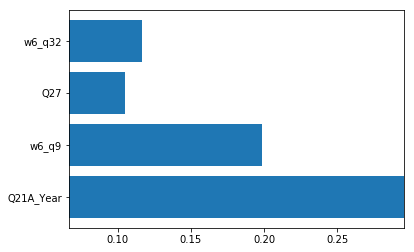

In [12]:
losses_df=variable_importance(model_rf, features, labels)
plot_importance(losses_df)

#### Logistic Regression

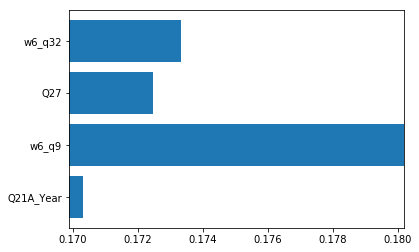

In [13]:
losses_df=variable_importance(model_lr, features, labels)
plot_importance(losses_df)

### PD, M i ALE plots dla zmiennych **Q21A_year** i **w6_q9**

##### Przypomnienie co znaczą zmienne
- **Q21A_Year** - w którym roku badany poznał partnera
- **w6_q9** - wiek partnera w 2017

Patrząc na wykresy od razu można zgadnąć, które wykresy opisują które modele z powodu kształtów krzywych PD-plot.

W przypadku **Random Forests** widać że na decyzję modelu większy wpływ ma zmienna **Q21A_Year**, ponieważ jej PD-plot jest o wiele bardziej zróżnicowany. Rónież w przypadku ALE-plota widać, że zmiana dla **Q21A_Year** jest bardzo duża, w porównaniu do ALE-plota dla **w6_q9**. Jednak w dalszym ciągu zmienna **w6_q9** jest dośyć ważna w tym modelu. Wynika to z konstrukcji lasów losowych o tym że do początkowego podziału brane są losowe zmienne, dlatego każda w jakimś stopniu ma wpływ na wynik. A że w tym przypadku obie wybrane przeze mnie zmienne są dosyć mocno skorelowane ich ważność i wpływ na wynik jest dosyć porównywalna.

Ciekawym przypadkiem natomiast są wykresy dla modelu **Regresji Logistycznej**, PD-plot dla **Q21A_Year** jest zupełnie płaski, co wraz z bardzo niewielką zmianą opisaną przez ALE-plot dla tej samej zmiennej, mówi tyle że nie ma ona prawie żadnego wpływu na wynik modelu.
Co ciekawe, zmienna **w6_q9** wydaje się przejmować większą część decyzji, kształt krzywej PD-plot wygląda wręcz jakby pozostałe zmienne miały bardzo znikomy wpływ na wynik. 

Poniżej dodatkowo wyznaczyłem wykres ważności zmiennych dla modelu **Regresji Logistycznej** bazującej na danych **bez** kolumny **Q21A_year**, żeby zobaczyć w jaki sposób zmieni się wynik. Uzyskaliśmy nawet delikatny wzrosta Accuracy! Widać dodakowo że zmienna **w6_q9** w zupełności przejeła odpowiedzialność za decyzję modelu, zmienne dyskretne nie mają zbyt dużego znaczenia patrząc na wykres ważności zmiennych.

Prawdopodobnie konstrukcja modelu regresji logistycznej powoduje, że w przypadku mocno skorelowanych zmiennych, jedna z nich przestaje być brana pod uwagę.

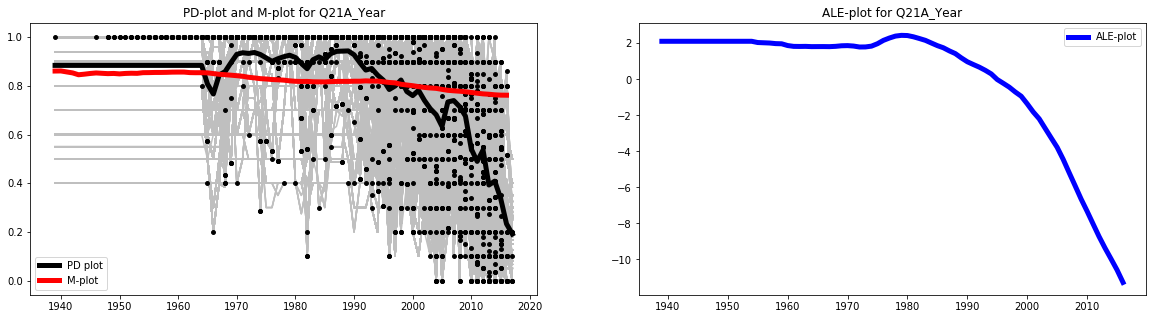

In [24]:
explain_model(model_rf, features, 0, 10)

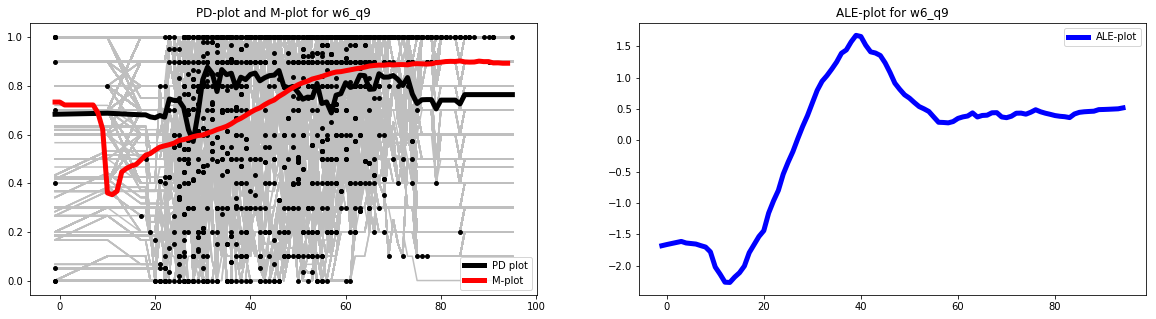

In [18]:
explain_model(model_rf, features, 1, 10)

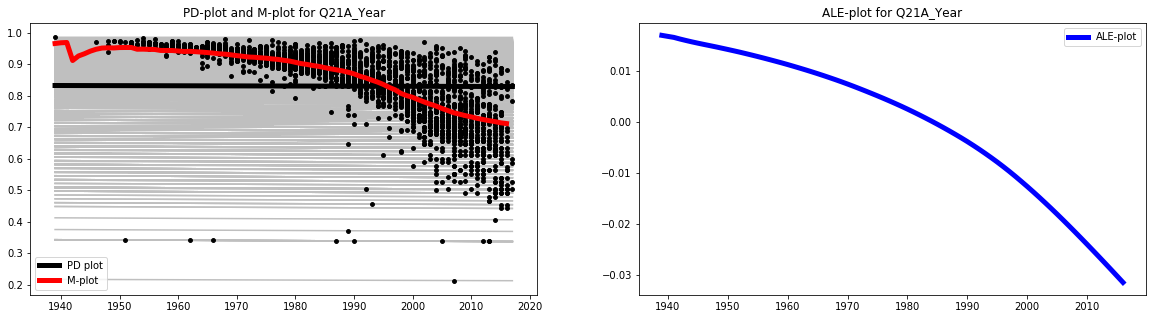

In [25]:
explain_model(model_lr, features, 0, 10)

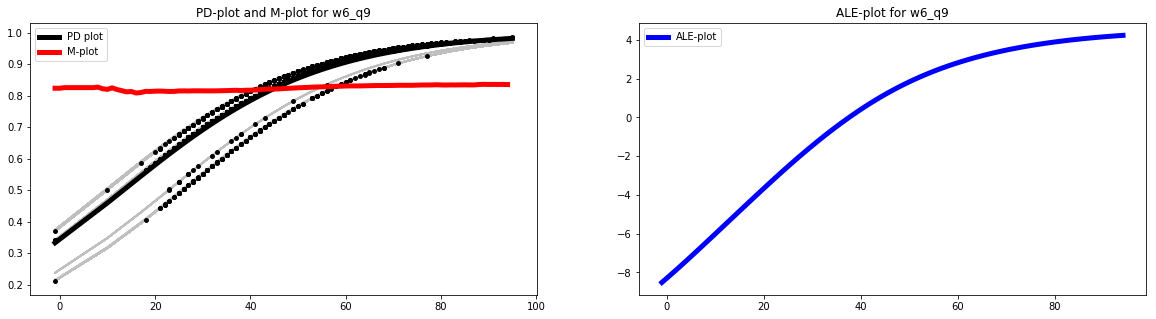

In [26]:
explain_model(model_lr, features, 1, 10)

### Model Regresji Logistycznej dla danych bez kolumy **Q21A_Year**

In [10]:
warnings.filterwarnings("ignore")
train_features_tmp = train_features.drop('Q21A_Year', axis=1)
test_features_tmp = test_features.drop('Q21A_Year', axis=1)
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(train_features_tmp,train_labels)  

predictions = model_lr.predict(test_features_tmp)
tested_labels = np.array(test_labels)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_lr, train_features_tmp, train_labels, cv = 4)
print('Skuteczność modelu to : '+'%2.2f' % (cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 82.98 %


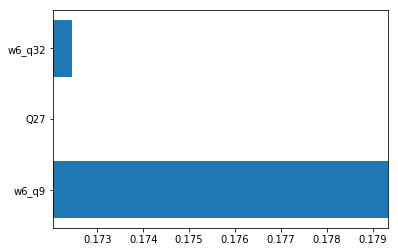

In [15]:
losses_df=variable_importance(model_lr, features.drop('Q21A_Year', axis=1), labels)
plot_importance(losses_df)

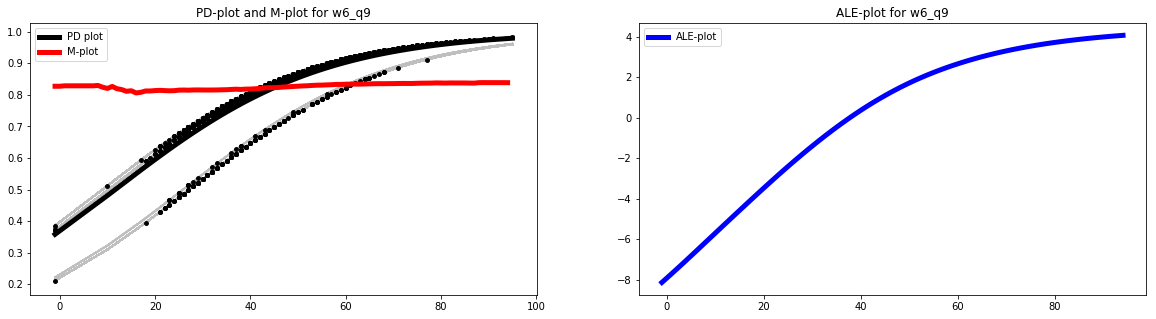

In [14]:
explain_model(model_lr, features.drop('Q21A_Year', axis=1), 0, 10)